In [1]:
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
tran = pd.read_csv('data/sample_transactions.csv').drop(['Unnamed: 0'], axis=1)
tran.head()

,dd_card_number,store_number,dd_transaction_number,sku,quantity,post_discount_price,date,hour,dbi_item_catgry,dbi_item_sub_catgry,dbi_item_famly_name,dbi_item_size
0,0,775,7969,74,1,2.29,9/2/2015,Lunch,Beverages,Hot Coffee,Hot Coffee,Large
1,0,775,7969,73,1,0.00,9/2/2015,Lunch,Beverages,Hot Coffee,Hot Coffee,Medium
2,0,761,16021,75,1,2.49,9/4/2015,Morning,Beverages,Hot Coffee,Hot Coffee,X-Large
3,0,761,16021,50,1,2.49,9/4/2015,Morning,Beverages,Hot Coffee,Hot Coffee,X-Large
4,0,761,16021,50,1,0.00,9/4/2015,Morning,Beverages,Hot Coffee,Hot Coffee,X-Large


## Clustering (20)

- Feature generation. Use examples from Seminar 6 Plan to generate features for products clustering. You may generate any number of features but you must generate at least 3 features which differ from those, proposed in the plan.
- Cluster all products into distinct groups (clusters). You may use any clustering algorithm you want. If you use distance-based clustering (e.g. k-means), do not forget to preprocess your features (normalization, z-scoring or standard scaling). Try a different number of groups (e.g. from 5 to 30). Couple of useful links for selection number of clusters:
- Write a report. In your report you should present the following information:
    - Put an example screenshot of your features.
    - Explain (in a similar way I explain them in the plan) every single feature (you may skip features from the seminar plan) you use.
    - Cluster’s information: how many clusters do you have, how many objects are in these clusters.
    - Cluster’s interpretation. Try to provide an interpretation of every single cluster (or groups of clusters) you end up.
    - You may include any visualization you find necessary, e.g.: colored PCA components, histogram or pie charts of cluster’s sizes, “elbows” used for selection number of clusters (if you have used it).


In [3]:
df = pd.DataFrame()

In [4]:
df['bought_by_customers_number'] = tran.groupby(['sku'])['dd_card_number'].nunique()
df['bought_in_different_hour_number'] = tran.groupby(['sku'])['hour'].nunique()
df['mean_price'] = tran.groupby('sku')['post_discount_price'].transform('mean')

df.head()

,bought_by_customers_number,bought_in_different_hour_number,mean_price
sku,,,
0,1,1,2.272133
1,5,3,1.898885
2,1,1,2.461702
3,17,2,2.155855
4,3,2,2.155855


In [5]:
df['mean_family_price'] = tran.groupby('dbi_item_famly_name')['post_discount_price'].transform('mean')
df['family_size'] = tran.groupby('dbi_item_famly_name')['sku'].transform('nunique') - 1 
df['freq'] = tran.groupby(['sku'])['date'].transform('nunique') / tran.date.nunique()

df.head()

,bought_by_customers_number,bought_in_different_hour_number,mean_price,mean_family_price,family_size,freq
sku,,,,,,
0,1,1,2.272133,2.128901,22,1.000000
1,5,3,1.898885,2.128901,22,1.000000
2,1,1,2.461702,2.128901,22,0.997260
3,17,2,2.155855,2.128901,22,0.323288
4,3,2,2.155855,2.128901,22,0.323288


In [6]:
scaler = StandardScaler()
sc_df = scaler.fit_transform(df)
sc_df

array([[-0.51052042, -1.07799872,  0.57234455,  0.49278604, -0.22260259,
         0.51279095],
       [-0.18696033,  0.6739258 , -0.00623809,  0.49278604, -0.22260259,
         0.51279095],
       [-0.51052042, -1.07799872,  0.86620167,  0.49278604, -0.22260259,
         0.50336185],
       ...,
       [ 0.05570974,  1.54988807, -0.00623809,  0.49278604, -0.22260259,
         0.51279095],
       [-0.51052042, -0.20203646, -1.18914577, -1.75872329,  2.10415736,
         0.51279095],
       [-0.18696033, -0.20203646,  0.57234455,  0.49278604, -0.22260259,
         0.51279095]])

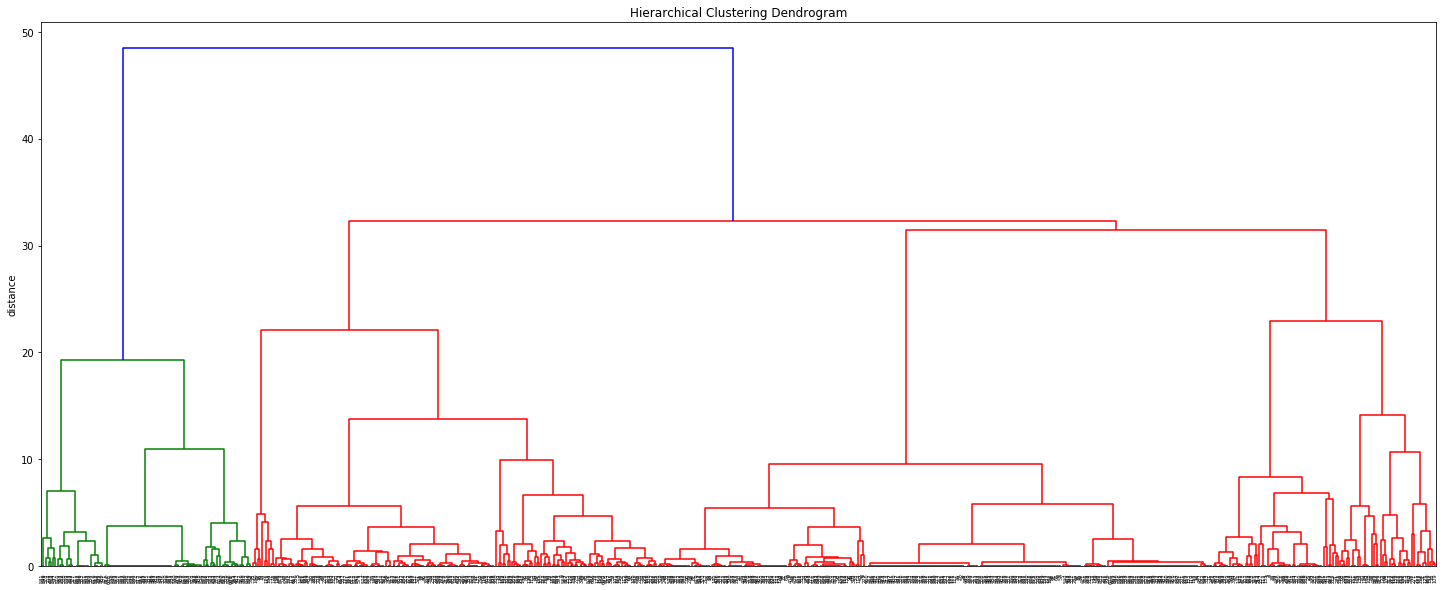

In [7]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram = sch.dendrogram(sch.linkage(sc_df, method='ward'))
plt.ylabel('distance')
plt.show()

In [8]:
sums = []
K = range(1, 100)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(sc_df)
    sums.append(km.inertia_)

100%|██████████| 99/99 [00:16<00:00,  6.05it/s]


[Text(0, 0.5, 'Sum of distances^2'), Text(0.5, 0, 'k')]

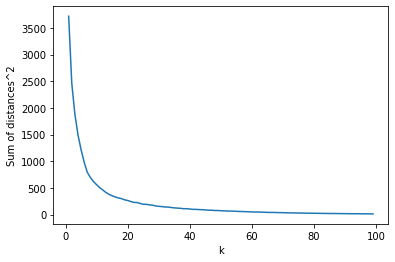

In [16]:
ax = sns.lineplot(x=K, y=sums)
ax.set(xlabel='k', ylabel='Sum of distances^2')

In [10]:
kmeans = KMeans(n_clusters=4)
predicted = kmeans.fit_predict(sc_df)

cl_df = df.copy()
cl_df['cl'] = predicted
cl_df.head()

,bought_by_customers_number,bought_in_different_hour_number,mean_price,mean_family_price,family_size,freq,cl
sku,,,,,,,
0,1,1,2.272133,2.128901,22,1.000000,2
1,5,3,1.898885,2.128901,22,1.000000,0
2,1,1,2.461702,2.128901,22,0.997260,2
3,17,2,2.155855,2.128901,22,0.323288,3
4,3,2,2.155855,2.128901,22,0.323288,3


In [11]:
df[cl_df.cl == 0].describe()

,bought_by_customers_number,bought_in_different_hour_number,mean_price,mean_family_price,family_size,freq
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,16.582888,3.486631,2.184722,2.074411,21.513369,0.970991
std,17.955361,0.511778,0.233745,0.240359,2.190788,0.115604
min,1.000000,2.000000,1.683362,1.008942,3.000000,0.323288
25%,5.000000,3.000000,1.898885,2.128901,22.000000,0.997260
50%,11.000000,3.000000,2.272133,2.128901,22.000000,1.000000
75%,19.500000,4.000000,2.272133,2.128901,22.000000,1.000000
max,99.000000,4.000000,2.461702,2.128901,22.000000,1.000000


In [12]:
df[cl_df.cl == 1].describe()

,bought_by_customers_number,bought_in_different_hour_number,mean_price,mean_family_price,family_size,freq
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,4.951923,2.067308,0.720785,1.258403,38.403846,0.750026
std,7.474721,1.117073,0.549571,0.081759,7.998203,0.343167
min,1.000000,1.000000,0.000000,1.008942,14.000000,0.002740
25%,1.000000,1.000000,0.000000,1.284941,41.000000,0.389041
50%,2.000000,2.000000,1.135783,1.284941,41.000000,1.000000
75%,5.000000,3.000000,1.135783,1.284941,41.000000,1.000000
max,44.000000,4.000000,1.135783,1.284941,41.000000,1.000000


In [13]:
df[cl_df.cl == 2].describe()

,bought_by_customers_number,bought_in_different_hour_number,mean_price,mean_family_price,family_size,freq
count,253.000000,253.000000,253.000000,253.000000,253.000000,253.000000
mean,1.837945,1.355731,2.193595,2.100839,21.600791,0.981948
std,1.477820,0.479683,0.255630,0.188253,2.263127,0.057063
min,1.000000,1.000000,1.493992,1.008942,3.000000,0.602740
25%,1.000000,1.000000,1.898885,2.128901,22.000000,0.997260
50%,1.000000,1.000000,2.272133,2.128901,22.000000,1.000000
75%,2.000000,2.000000,2.461702,2.128901,22.000000,1.000000
max,12.000000,2.000000,2.698418,3.020700,22.000000,1.000000


In [14]:
df[cl_df.cl == 3].describe()

,bought_by_customers_number,bought_in_different_hour_number,mean_price,mean_family_price,family_size,freq
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,5.947368,2.276316,1.859471,2.040702,16.907895,0.258039
std,7.402513,1.040496,0.497708,0.321460,7.813113,0.167133
min,1.000000,1.000000,0.000000,1.352051,3.000000,0.002740
25%,1.750000,1.000000,1.466019,2.068623,11.000000,0.144521
50%,3.000000,2.000000,2.155855,2.128901,22.000000,0.323288
75%,7.000000,3.000000,2.155855,2.128901,22.000000,0.323288
max,38.000000,4.000000,2.785000,3.020700,22.000000,0.846575
